In [ ]:
import numpy as np
import matplotlib.pyplot as plt


from scipy.io import savemat, loadmat

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Dense, Input, Layer, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from scipy import signal
from sklearn.model_selection import train_test_split

# Definimos parámetros globales del cuaderno:
Max_epoc = 250   # Número máximo de épocas a realizar en los entrenamientos
Num_epoc_sinmejorar = 3 # Número de épocas sin que la función de pérdidas se decremente antes de detener el entrenamiento.
batch_size = 128 # Tamaño del batch
L= 600 # -> Número de pesos del modelo convolucional lineal

# Definimos señales para entrenar:

np.random.seed(42)
N = 5000 #-> Duración de cada secuencia
I=30000 # -> Número de secuencias





# Tipos de no linealidades a considerar y modelos de no linealidades empleados:

* En el camino primario (respecto de la señal de referencia)
* En la señal de referencia (respecto de la señal de ruido que se propaga hacia el punto de control)
* En el camino secundario (en la generación de las señales. Por ejemplo, en el altavoz)
* En dos o más de las anteriores



## Definimos diferentes modelos de no-linealidades

Todos lo modelos propuestos menos el de Volterra son sin memoria.

* Modelo 1: $$x^{nl} (n) = 2a x(n) + ax^2(n) + x^3(n)$$

$a = log (\epsilon/10) + 0.1$, y $\epsilon = [2, 3, 4, 5]$.



* Modelo 2: $$x^{nl}(n) = 1 - e^{−0.3x(n)}$$



* Modelo 3: Saturación hard: -> entre -xmax y xmax   (típicos 0.7)



* Modelo 4: Saturación soft
$$ x^{nl}(n)=\frac{x(n)x_{max}}{\sqrt[q]{|x_{max}|^q+|x(n)|^q}}$$

* Modelo 5: Sigmoide

$$x^{nl}(k)=\lambda\left(\frac{1}{1+e^{-vz(n)}}-\frac{1}{2} \right) $$

$$z(n)=1.5x(n-0.3x^2(n)) $$
$$\lambda=2$$

$$v= \begin{cases} 4, z(n)>0 \\
0.5, z(n)\leq 0 \end{cases}$$

* Modelo 6: Kernel Volterra segundo orden
$$ x^{nl}(n) = h_0 +\sum_{k}h_1(k)x(n-k)+\sum_{k_1}\sum_{k_2}h_2(k_1,k_2)x(n-k_1)x(n-k_2) $$






In [ ]:
def no_linealidad(x,tipo=0, epsilon=2, b=0.3, lim=0.7, q=2, l=4, h0=np.array([0]), h1= np.array([1]), h2=np.array([[0.5, 0], [0 ,-0.2]]) ):

  N= len(x)
  if tipo ==1:
    a=np.log10(epsilon/10)+0.1
    y=2*a*x+a*x*x+x*x*x

  elif tipo ==2:
    y=1-np.exp(-b*x)

  elif tipo ==3:
    y=np.clip(x,-lim,lim)

  elif tipo ==4:
    max_x=np.max(x)
    y=x*max_x/(np.abs(max_x)**q+np.abs(x)**q)**(1/q)

  elif tipo ==5:
    z=1.5*x-0.3-x*x
    v=np.zeros(np.size(z))
    v[np.where(z>0)]=4
    v[np.where(z<=0)]=0.5

    y=l*(1/(1+np.exp(-v*z))-0.5)


  elif tipo ==6:
    M1 = len(h1)
    M2 = h2.shape[0]  # asumimos h2 es cuadrada: M2 x M2

    y = h0 + np.zeros(N)

    # Parte lineal (convolución simple)
    for n in range(N):
        for k in range(M1):
            if n - k >= 0:
                y[n] += h1[k] * x[n - k]

    # Parte cuadrática (doble sumatorio)
    for n in range(N):
        for k1 in range(M2):
            for k2 in range(M2):
                if n - k1 >= 0 and n - k2 >= 0:
                    y[n] += h2[k1, k2] * x[n - k1] * x[n - k2]

  else:  # Lineal
    y = x

  return y

# Equivalente usando operadores y funciones de tensorflow para poder usar los modelos de no linealidad en la función de pérdidas.
# El tipo de linealidad 6 (Volterra de 2º orden) no funciona dentro de la función de pérdidas, así que está comentado para poder usar al menos los otros modelos2

def no_linealidad_tf(x, tipo=0, epsilon=2.0, b=0.3, lim=0.7, q=2.0, l=4.0,
                     h0=tf.constant([0.0], dtype=tf.float32),
                     h1=tf.constant([1.0], dtype=tf.float32),
                     h2=tf.constant([[0.5, 0.0], [0.0, -0.2]], dtype=tf.float32)):
    x = tf.cast(x, tf.float32)  # Asegurarse de que todo sea float32

    def tipo1():
        a = tf.math.log(epsilon / 10.0) / tf.math.log(10.0) + 0.1
        return 2 * a * x + a * x**2 + x**3

    def tipo2():
        return 1.0 - tf.exp(-b * x)

    def tipo3():
        return tf.clip_by_value(x, -lim, lim)

    def tipo4():
        max_x = tf.reduce_max(x)
        num = x * max_x
        denom = tf.pow(tf.abs(max_x), q) + tf.pow(tf.abs(x), q)
        return num / tf.pow(denom, 1.0 / q)

    def tipo5():
        z = 1.5 * x - 0.3 - x**2
        v = tf.where(z > 0, 4.0, 0.5)
        return l * (1.0 / (1.0 + tf.exp(-v * z)) - 0.5)


#    def tipo6():
#        N = tf.shape(x)[0]
#        M1 = tf.shape(h1)[0]
#        M2 = tf.shape(h2)[0]

#        ta = tf.TensorArray(tf.float32, size=N, element_shape=[2])
#        n0 = tf.constant(0, dtype=tf.int32)

#        def body1(n, y_out):
#            acc_linear = tf.constant(0.0, dtype=tf.float32)
#            k = tf.constant(0, dtype=tf.int32)
#            def loop_linear(k, acc):
#                def add_term():
#                    return acc + h1[k] * x[n - k]
#                acc = tf.cond(n - k >= 0, add_term, lambda: acc)
#                return k + 1, acc

#            k = tf.constant(0, dtype=tf.int32)
#            acc_linear = tf.constant(0.0, dtype=tf.float32)
#            _, acc_linear = tf.while_loop(
#                lambda k, *_: k < M1,
#                loop_linear,
#                [k, acc_linear],
#                shape_invariants=[tf.TensorShape([]), tf.TensorShape([])]

#            )

#            def loop_quad(k1, acc_outer):
#                def loop_inner(k2, acc_inner):
#                    def add_term():
#                        return acc_inner + h2[k1, k2] * x[n - k1] * x[n - k2]
#                    acc_inner = tf.cond(tf.logical_and(n - k1 >= 0, n - k2 >= 0), add_term, lambda: acc_inner)
#                    return k2 + 1, acc_inner

#                k2 = tf.constant(0, dtype=tf.int32)
#                acc_inner = tf.constant(0.0, dtype=tf.float32)
#                _, acc_inner = tf.while_loop(
#                    lambda k2, *_: k2 < M2,
#                    loop_inner,
#                    [k2, acc_inner],
#                    shape_invariants=[tf.TensorShape([]), tf.TensorShape([])]

#                )
#                return k1 + 1, acc_outer + acc_inner

#            k1 = tf.constant(0, dtype=tf.int32)
#            acc_quad = tf.constant(0.0, dtype=tf.float32)
#            _, acc_quad = tf.while_loop(
#                lambda k1, *_: k1 < M2,
#                loop_quad,
#                [k1, acc_quad],
#                shape_invariants=[tf.TensorShape([]), tf.TensorShape([])]

#            )

#            y_val = h0[0] + acc_linear + acc_quad
#            y_out = y_out.write(n, y_val)
#            return n + 1, y_out

#        ta = tf.TensorArray(tf.float32, size=N)
#        n = tf.constant(0, dtype=tf.int32)
#        _, y_final = tf.while_loop(
#            lambda n, *_: n < N,
#            body1,
#            [n, ta],
#            shape_invariants=[tf.TensorShape([]), tf.TensorShape(None)]

#        )
#        return y_final.stack()








    def tipo_default():
        return x

    return tf.case([
        (tf.equal(tipo, 1), tipo1),
        (tf.equal(tipo, 2), tipo2),
        (tf.equal(tipo, 3), tipo3),
        (tf.equal(tipo, 4), tipo4),
        (tf.equal(tipo, 5), tipo5),
#        (tf.equal(tipo, 6), tipo6),
    ], default=tipo_default, exclusive=True)


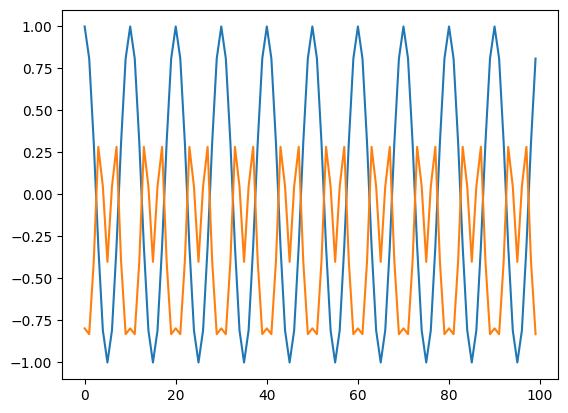

In [ ]:
# Visualizamos ejemplo de no linealidad sobre una señal tonal:
x=np.cos(2*np.pi*0.1*np.arange(100))
x = tf.cast(x, tf.float32)
plt.plot(x)

# Indicamos el modelo de no linealidad que queremos aplicar a la señal
tipo = 1

# Ambas llamadas siguientes deberían funcionar igual, pero solo la segunda usa eficientemente las funciones de TensorFlow sobre GPU y puede usarse en las funciones de pérdidas personalizadas

#y= no_linealidad(x,tipo)
y= no_linealidad_tf(x,tipo)

plt.plot(y);

## Definimos función de pérdidas y condición de fin de entrenamiento.

Definimos una función de pérdidas que incluya la propoagación acústica y que posibilite introducir alguno de los modelos de no linealidad descrito en dicha propagación. Esta función se empleará posterioremnte en los procesos de entrenamiento.

In [ ]:
# Definimos la función de pérdidas personalizada que incluye propagación lineal y posibilidad no linealidad en altavoces (para añadir, si es el caso, no linealidades en el camino secundario)
def custom_loss(S,nl=0):
    """
    Función de pérdidas personalizada que calcula el MSE entre los targets
    y la salida del modelo filtrada por el camino secunadario S.

    Entradas:
        filter_kernel (tf.Tensor): Tensor 1D de coeficientes del filtro (longitud P).
        modelo de no linealidad a aplicar (0 -> modelo lineal)

    Salidas:
        Objeto invocable: Función de pérdida para usar en un modelo de Keras.
    """
    M = S.size-1
    # Invertimos los coeficientes para que la convolución se comporte como un filtro lineal
    filtroinv=np.float32(S[::-1])
    # Expandir dimensiones del filtro para usarlo como kernel en convolución 1D
    filtro_tf = tf.reshape(filtroinv, (-1, 1, 1))

    def loss(y_true, y_pred):
        y_mod = no_linealidad_tf(y_pred, tipo=nl)

        # Filtrado directo mediante convolución 1D
        y_pred_filtered = tf.nn.conv1d(
            y_mod, filters=filtro_tf, stride=1, padding="VALID"
        )

        # Ajustar y_true para que coincida con el tamaño de y_pred_filtered

        y_true_cropped = y_true[:, M:, :]  # Recortar al principio



        # Calcular el MSE entre los targets y la salida filtrada
        mse = tf.reduce_mean(tf.square(y_true_cropped - y_pred_filtered))
        return mse

    return loss

# Definimos una métrica que devuelva la atenuación promedio obtenida sobre el batch

def custom_metric(S,nl=0):
    M = S.size-1
    # Invertimos los coeficientes para que la convolución se comporte como un filtro lineal
    filtroinv=np.float32(S[::-1])
    # Expandir dimensiones del filtro para usarlo como kernel en convolución 1D
    filtro_tf = tf.reshape(filtroinv, (-1, 1, 1))


    def At_dB(y_true, y_pred):

        y_mod = no_linealidad_tf(y_pred, tipo=nl)
        # Filtrado directo mediante convolución 1D
        y_pred_filtered = tf.nn.conv1d(
            y_mod, filters=filtro_tf, stride=1, padding="VALID"
        )

        # Ajustar y_true para que coincida con el tamaño de y_pred_filtered

        y_true_cropped = y_true[:, M:, :]  # Recortar al principio

        mse_seq = tf.reduce_mean(tf.square(y_true_cropped - y_pred_filtered), axis=1)  # (batch_size,)
        power_seq = tf.reduce_mean(tf.square(y_true_cropped), axis=1)        # (batch_size,)

        # Evitamos división por cero
        ratio = mse_seq / (power_seq + 1e-10)

        At = 10.0 * tf.math.log(1.0 / ratio) / tf.math.log(10.0)

        # Promediamos PSNR sobre batch
        return tf.reduce_mean(At)

    return At_dB


In [ ]:
# Definimos una función para detener automáticamente el entrenamiento si se estanca la convergencia
early_stop = EarlyStopping(
    monitor='loss',      # Monitoriza la pérdida en datos de entrenamiento
    patience=Num_epoc_sinmejorar,              # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaura automáticamente los mejores pesos
)   # Definimos una parada automática cuando el modelo empeora

# Definimos un sistema acústico 1x1x1 para realizar simulaciones

In [ ]:
# Cargamos archivo con las respuestas al impulso
import gdown

file_id = '1_tf_ODBO9dDHyoyD_Bx9EO41-ijMjf2s'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'rirANC1x1.mat', quiet=False)

data = loadmat('rirANC1x1.mat')

# data es un diccionario con diversas variables entre las que se encuentran 'Pri', que es una estructura con la respuesta al impulso del camino primario y 'Sec' que contiene el secundario:
P = data['Pri']
S = data['Sec']

M=np.size(S)  # -> Número de coefecientes del sistema de propagación

Downloading...
From (original): https://drive.google.com/uc?id=1_tf_ODBO9dDHyoyD_Bx9EO41-ijMjf2s
From (redirected): https://drive.google.com/uc?id=1_tf_ODBO9dDHyoyD_Bx9EO41-ijMjf2s&confirm=t&uuid=9360806b-c328-47a6-845e-f74c5739de72
To: /content/rirANC1x1.mat
100%|██████████| 3.31k/3.31k [00:00<00:00, 7.69MB/s]


# Generamos base de datos del entrenamiento

In [ ]:
# Generación de datos de entrenamiento
X = np.float32(np.random.randn(I, N, 1))  # Predictores o Señales de entrada (ruido blanco)
d0 = np.array([signal.lfilter(P[:,0],1, x.flatten()) for x in X])  # target
d = np.float32(d0.reshape(I,N,1))

# División de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, d, test_size=0.2, random_state=42)

# Definimos un modelo (RN) Lineal para ANC (a usar como referencia)

In [ ]:
# Definimos función para crear modelo Lineal 1x1x1 basado en CNN 1D

def crea_modelo_lineal(Tam_FA=100):
  return Sequential([
    Input(shape=(None, 1)),
    Conv1D(filters=1, kernel_size=Tam_FA, activation='linear', padding='valid', use_bias=False),
    ])



### Empleamos el modelo lineal, en un sistema ANC sin no linealidades

In [ ]:
# Creamos un modelo lineal con filtro adaptativo de 600 coeficientes:
modelo_lineal=crea_modelo_lineal(L)

In [ ]:
# Compilamos el modelo usando la función de pérdidas previamente definida
loss_fn = custom_loss(S)
metric_fn = custom_metric(S)

modelo_lineal.compile(optimizer='adam', loss=loss_fn, metrics= [metric_fn])

In [ ]:
# Entrenamos el modelo
history=modelo_lineal.fit(X_train, -y_train[:,L-1:],epochs=Max_epoc, batch_size=batch_size, validation_data=(X_val, -y_val[:,L-1:]),callbacks=[early_stop])

Epoch 1/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - at_d_b: -12.4425 - loss: 0.1259 - val_at_d_b: 12.7792 - val_loss: 9.5896e-05
Epoch 2/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 15.1806 - loss: 5.9732e-05 - val_at_d_b: 19.9992 - val_loss: 1.8290e-05
Epoch 3/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 20.9705 - loss: 1.4895e-05 - val_at_d_b: 23.4648 - val_loss: 8.2810e-06
Epoch 4/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - at_d_b: 24.1227 - loss: 7.1856e-06 - val_at_d_b: 26.0375 - val_loss: 4.5925e-06
Epoch 5/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 26.6071 - loss: 4.0576e-06 - val_at_d_b: 28.2660 - val_loss: 2.7533e-06
Epoch 6/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 28.7736 - loss: 2.4628e-06 - val_at_d_b: 30.2324 - val_loss: 1.7514e-06
Epoch 7/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - at_d_b: 30.7027 - loss: 1.5784e-06 - val_at_d_b: 32.0225 - val_loss: 1.1598e-06
Epoch 8/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/st

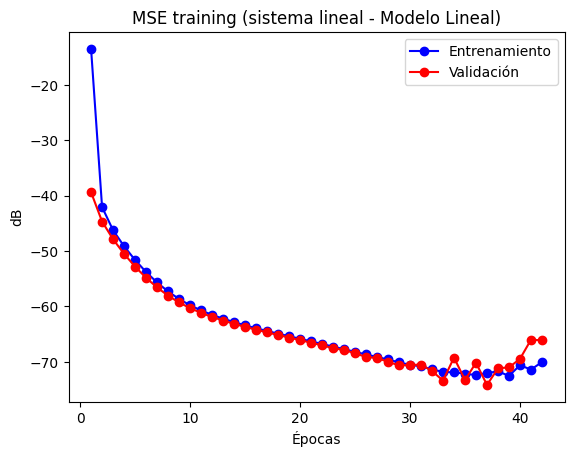

In [ ]:
# Visualizamos evolución del entrenamiento (curvas de aprendizaje)
loss_l = history.history['loss']
epochs = range(1, len(loss_l) + 1)
val_l = history.history['val_loss']
plt.figure()
plt.plot(epochs, 10*np.log10(loss_l), '-bo')
plt.plot(epochs, 10*np.log10(val_l), '-ro')
plt.legend(['Entrenamiento','Validación'])
plt.title('MSE training (sistema lineal - Modelo Lineal)')
plt.xlabel('Épocas')
plt.ylabel('dB');

Atenuación lograda: 43.54423419443585 dB


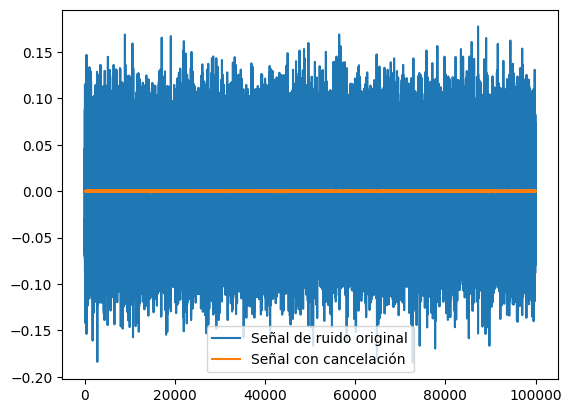

In [ ]:
# Comprobamos las prestaciones mediante procesado off-line
Ite=100000  # Número de muestras de ruido (iteraciones, en caso de procesado muestra a muestra, a considerar)
x=np.random.randn(Ite)  # Creamos una señal de referencia
d1 = np.array([signal.lfilter(P[:,0],1,x.flatten())])  # Simulamos propagación (obtnemos señal de ruido)

xr = np.concatenate((np.zeros(L-1),x))
y1 = modelo_lineal.predict(xr.reshape(1,len(xr),1),verbose='False')  # Obtenemos la señal que generaría la RN y reproduciría el altavoz
d1_e = signal.lfilter(S[:,0],1,y1.flatten())  # Simulamos la propagación acústica de la señal generada

plt.plot(d1.flatten())
e = d1.flatten() + d1_e.flatten()
plt.plot(e)  # Simulamos la suma acústica
plt.legend(['Señal de ruido original','Señal con cancelación']);
print('Atenuación lograda:', 10*np.log10(np.mean(d1.flatten()[1000:]**2)/np.mean(e[1000:]**2)),'dB')

### Empleamos modelo lineal en un sistema ANC con no linealidad en el camino primario

In [ ]:
# Generamos no linealidad en el camino primario e intentamos obtener un modelo lineal:

# Definimos el tipo de no linealidad de entre las modeladas a considerar:
tipo = 1
# Introducimos No linealidad
d2 = no_linealidad(d0,tipo)
d2 = np.float32(d2.reshape(I,N,1))

# División de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, d2, test_size=0.2, random_state=42)

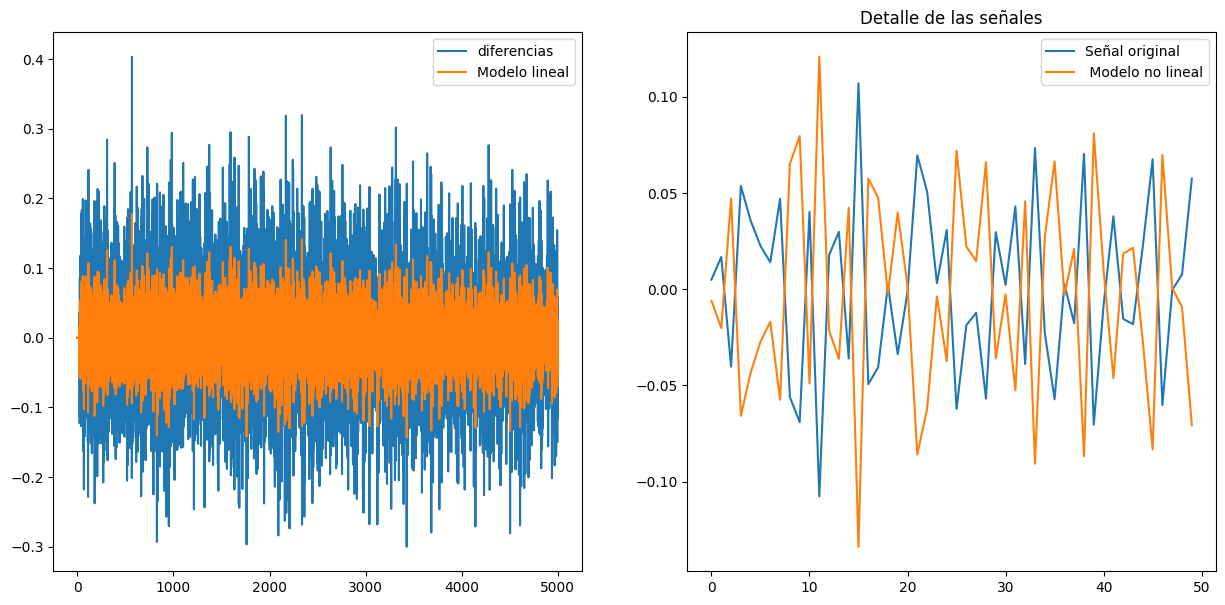

In [ ]:
# Visualizamos (por curiosidad) la diferencias entre la señal original y su modelo no lineal
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(d0[1,:]-d2[1,:,0])
plt.plot(d0[1,:])
plt.legend(['diferencias','Modelo lineal']);

plt.subplot(1,2,2)
plt.plot(d[1,100:150])
plt.plot(d2[1,100:150,0])
plt.title('Detalle de las señales')
plt.legend(['Señal original',' Modelo no lineal']);



In [ ]:
# Creamos el modelo
modelo2 = crea_modelo_lineal(L)
modelo2.compile(optimizer='adam', loss=loss_fn,metrics= [metric_fn])



In [ ]:
# Entrenamos el modelo
history=modelo2.fit(X_train, -y_train[:,L-1:],epochs=Max_epoc, batch_size=batch_size, validation_data=(X_val, -y_val[:,L-1:]),callbacks=[early_stop])

Epoch 1/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - at_d_b: -11.4241 - loss: 0.1434 - val_at_d_b: 13.7793 - val_loss: 1.0875e-04
Epoch 2/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - at_d_b: 16.2841 - loss: 6.6958e-05 - val_at_d_b: 21.8483 - val_loss: 1.6952e-05
Epoch 3/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 22.9298 - loss: 1.3464e-05 - val_at_d_b: 25.2538 - val_loss: 7.7313e-06
Epoch 4/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 25.6759 - loss: 7.0362e-06 - val_at_d_b: 26.6410 - val_loss: 5.6110e-06
Epoch 5/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - at_d_b: 26.8440 - loss: 5.3559e-06 - val_at_d_b: 27.3179 - val_loss: 4.7997e-06
Epoch 6/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 27.4246 - loss: 4.6841e-06 - val_at_d_b: 27.6659 - val_loss: 4.4299e-06
Epoch 7/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 27.7247 - loss: 4.3705e-06 - val_at_d_b: 27.8628 - val_loss: 4.2331e-06
Epoch 8/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/st

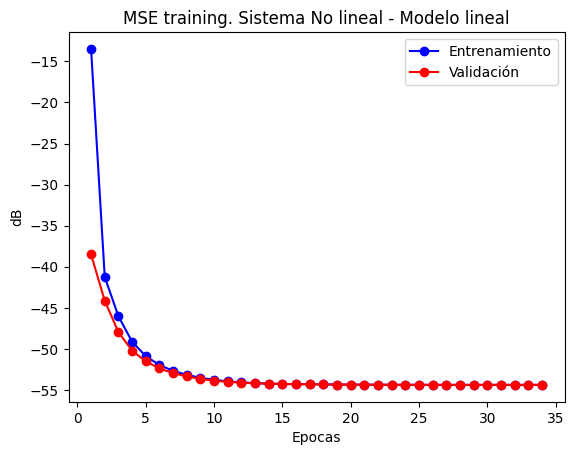

In [ ]:
# Visualizamos evolución del entrenamiento
loss_l2 = history.history['loss']
val_l2 = history.history['val_loss']


epochs = range(1, len(loss_l2) + 1)
plt.figure()
plt.plot(epochs, 10*np.log10(loss_l2), '-bo')
plt.plot(epochs, 10*np.log10(val_l2), '-ro')
plt.legend(['Entrenamiento','Validación'])

plt.title('MSE training. Sistema No lineal - Modelo lineal')
plt.xlabel('Epocas')
plt.ylabel('dB');

Atenuación lograda: 28.47316240848354 dB


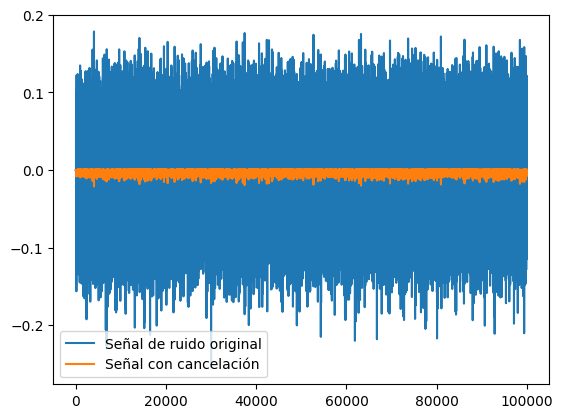

In [ ]:
# Comprobamos prestaciones de atenuación mediante procesado off-line
Ite=100000  # Número de muestras de ruido (iteraciones, en caso de procesado muestra a muestra, a considerar)
x=np.random.randn(Ite)  # Creamos una señal de referencia
d1 = np.array([signal.lfilter(P[:,0],1,x.flatten())])  # Simulamos propagación (obtnemos señal de ruido)
# Añadimos la no linealidad
d1 = no_linealidad(d1,tipo)

xr = np.concatenate((np.zeros(L-1),x))
y1 = modelo2.predict(xr.reshape(1,len(xr),1),verbose='False')  # Obtenemos la señal que generaría la RN y reproduciría el altavoz
d1_e = signal.lfilter(S[:,0],1,y1.flatten())  # Simulamos la propagación acústica de la señal generada

plt.plot(d1.flatten())
e = d1.flatten() + d1_e.flatten()
plt.plot(e)  # Simulamos la suma acústica
plt.legend(['Señal de ruido original','Señal con cancelación']);
print('Atenuación lograda:', 10*np.log10(np.mean(d1.flatten()[1000:]**2)/np.mean(e[1000:]**2)),'dB')



### Empleamos modelo lineal en un sistema ANC con no linealidad en la señal de referencia

In [ ]:
# Generamos no linealidad en la señal de referencia e intentamos obtener un modelo lineal:

# Definimos el tipo de no lienalidad de entre las modeladas a considerar:
tipo = 1

# No linealidad
Xnl = no_linealidad(X.reshape(I*N,1),tipo)
Xnl = np.float32(Xnl.reshape(I,N,1))

# División de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(Xnl, d, test_size=0.2, random_state=42)

In [ ]:
# Definimos el modelo:
modelo3 = crea_modelo_lineal(L)
modelo3.compile(optimizer='adam', loss=loss_fn, metrics= [metric_fn])




In [ ]:
# Entrenamos el modelo
history=modelo3.fit(X_train, -y_train[:,L-1:],epochs=Max_epoc, batch_size=batch_size, validation_data=(X_val, -y_val[:,L-1:]),callbacks=[early_stop])

Epoch 1/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - at_d_b: -22.7715 - loss: 1.3273 - val_at_d_b: -1.7208 - val_loss: 0.0027
Epoch 2/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - at_d_b: -1.0148 - loss: 0.0023 - val_at_d_b: 0.2888 - val_loss: 0.0017
Epoch 3/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - at_d_b: 0.5158 - loss: 0.0016 - val_at_d_b: 1.0295 - val_loss: 0.0014
Epoch 4/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 1.1352 - loss: 0.0014 - val_at_d_b: 1.3770 - val_loss: 0.0013
Epoch 5/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - at_d_b: 1.4246 - loss: 0.0013 - val_at_d_b: 1.5295 - val_loss: 0.0013
Epoch 6/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 1.5517 - loss: 0.0013 - val_at_d_b: 1.5950 - val_loss: 0.0013
Epoch 7/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 1.6045 - loss: 0.0013 - val_at_d_b: 1.6284 - val_loss: 0.0012
Epoch 8/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 1.6356 - loss: 0.0012 - val_at_d_b: 1.6494 - val_lo

In [ ]:
# Visualizamos evolución del entrenamiento
loss_l3 = history.history['loss']
val_l3 = history.history['val_loss']
epochs = range(1, len(loss_l3) + 1)
plt.figure()
plt.plot(epochs, 10*np.log10(loss_l3), '-bo')
plt.plot(epochs, 10*np.log10(val_l3), '-ro')
plt.legend(['Entrenamiento','Validación'])
plt.title('MSE training. Sistema No lineal - Modelo lineal')
plt.xlabel('Epocas')
plt.ylabel('dB');

Atenuación lograda: 1.7026089299413647 dB


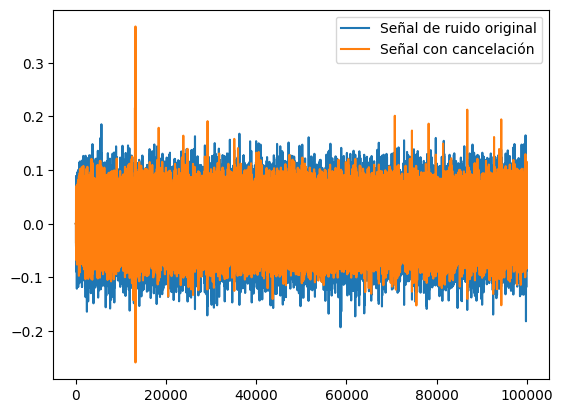

In [ ]:
# Comprobamos prestaciones de atenuación mediante procesado off-line
Ite=100000  # Número de muestras de ruido (iteraciones, en caso de procesado muestra a muestra, a considerar)
x=np.random.randn(Ite)  # Creamos una señal de referencia
d1 = np.array([signal.lfilter(P[:,0],1,x.flatten())])  # Simulamos propagación (obtnemos señal de ruido)

xnl = no_linealidad(x,tipo)

xr = np.concatenate((np.zeros(L-1),xnl))
y1 = modelo3.predict(xr.reshape(1,len(xr),1),verbose='False')  # Obtenemos la señal que generaría la RN y reproduciría el altavoz
d1_e = signal.lfilter(S[:,0],1,y1.flatten())  # Simulamos la propagación acústica de la señal generada

plt.plot(d1.flatten())
e = d1.flatten() + d1_e.flatten()
plt.plot(e)  # Simulamos la suma acústica
plt.legend(['Señal de ruido original','Señal con cancelación']);
print('Atenuación lograda:', 10*np.log10(np.mean(d1.flatten()[1000:]**2)/np.mean(e[1000:]**2)),'dB')


### Empleamos modelo lineal en un sistema ANC con no linealidad en el camino secundario

In [ ]:
# Generamos no linealidad en el camino secundario (añadiendo la no linealidad en la función de pérdidas personalizada) e intentamos obtener un modelo lineal:

# Definimos el tipo de no lienalidad de entre las modeladas a considerar:
tipo = 1

# División de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, d, test_size=0.2, random_state=42)

In [ ]:
# DEfinimos el modelo
modelo4 = crea_modelo_lineal(L)
# Redefinimos función de pérdidas para que considere la no linealidad
loss_fn = custom_loss(S,tipo)
metric_fn = custom_metric(S,tipo)
modelo4.compile(optimizer='adam', loss=loss_fn, metrics= [metric_fn])


In [ ]:
# Entrenamos el modelo
history=modelo4.fit(X_train, -y_train[:,L-1:],epochs=Max_epoc, batch_size=batch_size, validation_data=(X_val, -y_val[:,L-1:]),callbacks=[early_stop])

Epoch 1/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - at_d_b: -22.1535 - loss: 0.9102 - val_at_d_b: -14.9478 - val_loss: 0.0567
Epoch 2/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: -14.2656 - loss: 0.0490 - val_at_d_b: -11.6412 - val_loss: 0.0265
Epoch 3/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - at_d_b: -10.3362 - loss: 0.0203 - val_at_d_b: -5.8973 - val_loss: 0.0071
Epoch 4/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - at_d_b: -4.3920 - loss: 0.0052 - val_at_d_b: -0.3180 - val_loss: 0.0020
Epoch 5/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 0.7481 - loss: 0.0016 - val_at_d_b: 3.4856 - val_loss: 8.1503e-04
Epoch 6/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - at_d_b: 4.2072 - loss: 6.9714e-04 - val_at_d_b: 6.1421 - val_loss: 4.4263e-04
Epoch 7/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 6.7075 - loss: 3.9106e-04 - val_at_d_b: 8.2941 - val_loss: 2.6977e-04
Epoch 8/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - at_d_b: 8.7936 - loss: 2.416

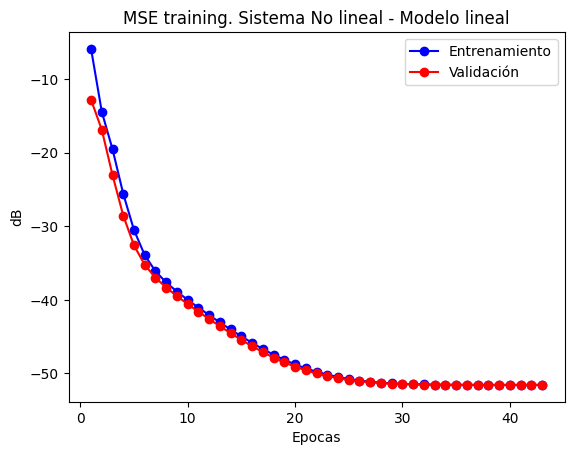

In [ ]:
# Visualizamos evolución del entrenamiento
loss_l4 = history.history['loss']
val_l4 = history.history['val_loss']
epochs = range(1, len(loss_l4) + 1)
plt.figure()
plt.plot(epochs, 10*np.log10(loss_l4), '-bo')
plt.plot(epochs, 10*np.log10(val_l4), '-ro')
plt.legend(['Entrenamiento','Validación'])
plt.title('MSE training. Sistema No lineal - Modelo lineal')
plt.xlabel('Epocas')
plt.ylabel('dB');

Atenuación lograda: 24.159263906319367 dB


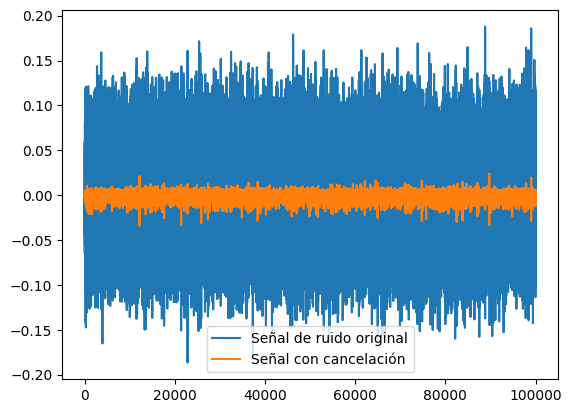

In [ ]:
# Comprobamos prestaciones de atenuación mediante procesado off-line
Ite=100000  # Número de muestras de ruido (iteraciones, en caso de procesado muestra a muestra, a considerar)
x=np.random.randn(Ite)  # Creamos una señal de referencia
d1 = np.array([signal.lfilter(P[:,0],1,x.flatten())])  # Simulamos propagación (obtnemos señal de ruido)


xr = np.concatenate((np.zeros(L-1),x))
y1 = modelo4.predict(xr.reshape(1,len(xr),1),verbose='False')  # Obtenemos la señal que generaría la RN y reproduciría el altavoz
# Añadimos no linealidad:
y1 = no_linealidad(y1,tipo);
d1_e = signal.lfilter(S[:,0],1,y1.flatten())  # Simulamos la propagación acústica de la señal generada

plt.plot(d1.flatten())
e = d1.flatten() + d1_e.flatten()
plt.plot(e)  # Simulamos la suma acústica
plt.legend(['Señal de ruido original','Señal con cancelación']);
print('Atenuación lograda:', 10*np.log10(np.mean(d1.flatten()[1000:]**2)/np.mean(e[1000:]**2)),'dB')

### Empleamos modelo lineal en un sistema ANC con no linealidades en cualquiera de sus elementos

Aparentemente el modelo lineal es más robusto a las no linealidades en el camino primario y más sensible a las no linealidades en la señal de referencia.

Las siguiente celda aplica el modelo lineal a la combinación de no linealidades deseada en cualquiera de los elementos:

In [ ]:
# Definimos modelo de no linealidad en cada elemento:
nl_primario = 1
nl_referencia = 0  # El modelo simple con no linealidades deifinido posteriormente no funciona bien para las no linealidades en la señal de referencia
nl_secundario = 1

# Introducción de no linealidades:

dnl = no_linealidad(d0.reshape(I*N,1),nl_primario)
dnl = np.float32(dnl.reshape(I,N,1))

Xnl = no_linealidad(X.reshape(I*N,1),nl_referencia)
Xnl = np.float32(Xnl.reshape(I,N,1))

loss_fn = custom_loss(S,nl_secundario)
metric_fn = custom_metric(S,nl_secundario)


# División de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(Xnl, dnl, test_size=0.2, random_state=42)


# Definimos el modelo:
modelo5 = crea_modelo_lineal(L)
modelo5.compile(optimizer='adam', loss=loss_fn, metrics=[metric_fn])

In [ ]:
# Entrenamos el modelo
history=modelo5.fit(X_train, -y_train[:,L-1:],epochs=Max_epoc, batch_size=batch_size, validation_data=(X_val, -y_val[:,L-1:]),callbacks=[early_stop])



Epoch 1/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - at_d_b: -20.1646 - loss: 0.7887 - val_at_d_b: -13.1356 - val_loss: 0.0532
Epoch 2/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: -12.3314 - loss: 0.0448 - val_at_d_b: -9.2417 - val_loss: 0.0217
Epoch 3/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - at_d_b: -7.8195 - loss: 0.0163 - val_at_d_b: -3.2365 - val_loss: 0.0054
Epoch 4/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: -1.7427 - loss: 0.0040 - val_at_d_b: 2.3844 - val_loss: 0.0015
Epoch 5/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - at_d_b: 3.5124 - loss: 0.0012 - val_at_d_b: 6.4670 - val_loss: 5.8420e-04
Epoch 6/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - at_d_b: 7.2039 - loss: 4.9852e-04 - val_at_d_b: 9.1508 - val_loss: 3.1540e-04
Epoch 7/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 9.6531 - loss: 2.8230e-04 - val_at_d_b: 11.0844 - val_loss: 2.0215e-04
Epoch 8/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - at_d_b: 11.4912 - loss: 1.8478e

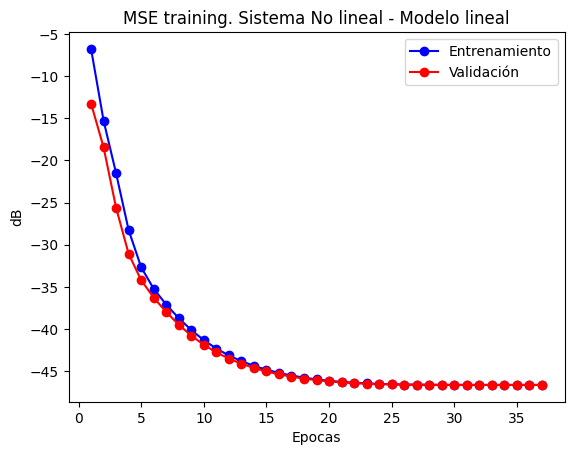

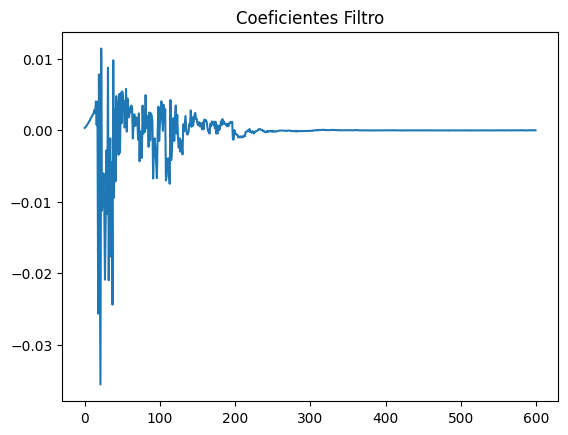

In [ ]:
# Visualizamos evolución del entrenamiento
loss_l5 = history.history['loss']
epochs = range(1, len(loss_l5) + 1)
val_l5 = history.history['val_loss']
plt.figure()
plt.plot(epochs, 10*np.log10(loss_l5), '-bo')
plt.plot(epochs, 10*np.log10(val_l5), '-ro')
plt.legend(['Entrenamiento','Validación'])
plt.title('MSE training. Sistema No lineal - Modelo lineal')
plt.xlabel('Epocas')
plt.ylabel('dB');

#Visualizamos el filtro obtenido
plt.figure()
w = np.array(modelo5.layers[0].weights)[0,::-1,0,0]
plt.plot(w)
plt.title('Coeficientes Filtro');

Atenuación lograda: 20.674316355290582 dB


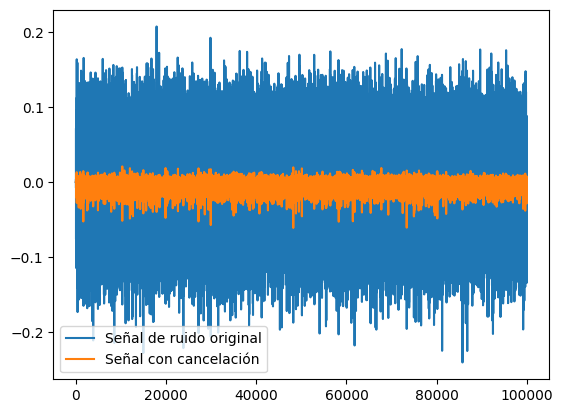

In [ ]:
# Comprobamos prestaciones de atenuación mediante procesado off-line
Ite=100000  # Número de muestras de ruido (iteraciones, en caso de procesado muestra a muestra, a considerar)
x=np.random.randn(Ite)  # Creamos una señal de referencia
d1 = np.array([signal.lfilter(P[:,0],1,x.flatten())])  # Simulamos propagación (obtnemos señal de ruido)

#Añadimos no lienalidad en el primario
d1 = no_linealidad(d1,nl_primario)

#Añadimos no linealidad en referencia
x = no_linealidad(x,nl_referencia)

xr = np.concatenate((np.zeros(L-1),x))
y1 = modelo5.predict(xr.reshape(1,len(xr),1),verbose='False')  # Obtenemos la señal que generaría la RN y reproduciría el altavoz
# Añadimos no linealidad en secudario:
y1 = no_linealidad(y1,nl_secundario);

d1_e = signal.lfilter(S[:,0],1,y1.flatten())  # Simulamos la propagación acústica de la señal generada

plt.plot(d1.flatten())
e = d1.flatten() + d1_e.flatten()
plt.plot(e)  # Simulamos la suma acústica
plt.legend(['Señal de ruido original','Señal con cancelación']);
print('Atenuación lograda:', 10*np.log10(np.mean(d1.flatten()[1000:]**2)/np.mean(e[1000:]**2)),'dB')

# Proponemos un modelo (RN) con no linealidades para ANC

Considerando $y(n)$ la salida del modelo lineal, proponemos un nuevo modelo cuya salida sea: $$y_{nl}(n) = \sum_{m=1}^M a_m f_m\{y(n)\}, $$ donde $a_m$ son pesos entrenables del modelo y $f_m\{·\}$ son funciones no lineales a definir.

Como primera aproximación se propondrán tres funciones: La lineal, la tangente hiperbólica y la polinómica. Como esta última no está definida, la creamos:

In [ ]:
# Definimos una función de activación polinómica:

class Polinomio(Layer):
    def __init__(self, grado=3, **kwargs):
        super(Polinomio, self).__init__(**kwargs)
        self.grado = grado

    def build(self, input_shape):
        # Creamos un coeficiente por cada término del polinomio: a_0, a_1, ..., a_grado
        self.coeficientes = self.add_weight(
            shape=(self.grado + 1,),
            initializer="random_normal",
            trainable=True,
            name="coeficientes_polinomio"
        )

    def call(self, inputs):
        # Calculamos: a_0 + a_1*x + a_2*x^2 + ... + a_n*x^n
        x = tf.cast(inputs, tf.float32)
        salida = tf.zeros_like(x)
        for i in range(self.grado + 1):
            salida += self.coeficientes[i] * tf.pow(x, i)
        return salida


In [ ]:
# Definimos función para crear modelo Lineal 1x1x1 basado en CNN 1D y añadiendo activaciones lineales que se combinan

def crea_modelo_nolineal(Tam_FA=100, grado=3):

    input_layer = Input(shape=(None, 1))
    conv_lineal = Conv1D(filters=1, kernel_size=Tam_FA, activation='linear', padding='valid', use_bias=False)(input_layer)

    # Aplicar diferentes funciones de activación no lineales
    act1 = Activation('tanh')(conv_lineal)
    act2 = Polinomio(grado=3)(conv_lineal)
    # Concatenar resultados: lienal, tanh y polinomio orden 3
    concat_acts = Concatenate(axis=-1)([conv_lineal, act1, act2])

    # Combinación lineal con pesos entrenables
    salida = Dense(1, use_bias=False)(concat_acts)
    modelo = Model(inputs=input_layer, outputs=salida)
    return modelo



In [ ]:
# Creamos el modelo no lineal
modelo_nl = crea_modelo_nolineal(L)
modelo_nl.compile(optimizer='adam', loss=loss_fn, metrics=[metric_fn])

Como el modelo es más complejo, necesitamos más entrenamiento para ajustarlo

In [ ]:
#Entrenamos el modelo
history=modelo_nl.fit(X_train, -y_train[:,L-1:],epochs=Max_epoc, batch_size=batch_size, validation_data=(X_val, -y_val[:,L-1:]),callbacks=[early_stop])

Epoch 1/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - at_d_b: -16.3002 - loss: 0.2229 - val_at_d_b: -10.3561 - val_loss: 0.0280
Epoch 2/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - at_d_b: -8.5978 - loss: 0.0199 - val_at_d_b: -2.6971 - val_loss: 0.0048
Epoch 3/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: -0.8136 - loss: 0.0033 - val_at_d_b: 4.1638 - val_loss: 9.9113e-04
Epoch 4/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - at_d_b: 5.4066 - loss: 7.6522e-04 - val_at_d_b: 8.5167 - val_loss: 3.6446e-04
Epoch 5/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - at_d_b: 9.2378 - loss: 3.1176e-04 - val_at_d_b: 11.0959 - val_loss: 2.0150e-04
Epoch 6/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 11.5654 - loss: 1.8165e-04 - val_at_d_b: 12.8820 - val_loss: 1.3358e-04
Epoch 7/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - at_d_b: 13.2503 - loss: 1.2304e-04 - val_at_d_b: 14.3206 - val_loss: 9.5909e-05
Epoch 8/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - at_d_b: 14.62

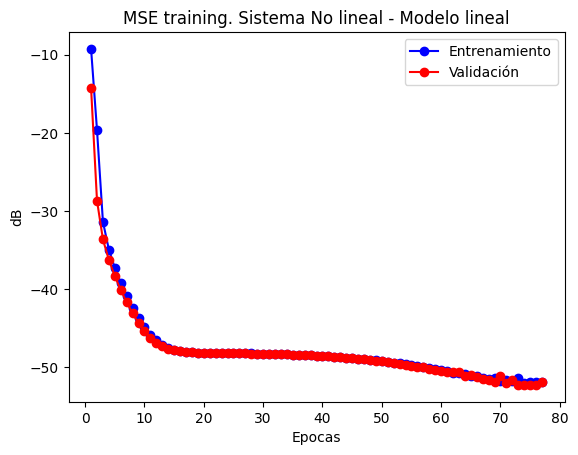

In [ ]:
# Visualizamos evolución del entrenamiento
loss_nl = history.history['loss']
epochs = range(1, len(loss_nl) + 1)
val_nl = history.history['val_loss']
plt.figure()
plt.plot(epochs, 10*np.log10(loss_nl), '-bo')
plt.plot(epochs, 10*np.log10(val_nl), '-ro')
plt.legend(['Entrenamiento','Validación'])
plt.title('MSE training. Sistema No lineal - Modelo lineal')
plt.xlabel('Epocas')
plt.ylabel('dB');

Atenuación lograda: 26.3792291419279 dB


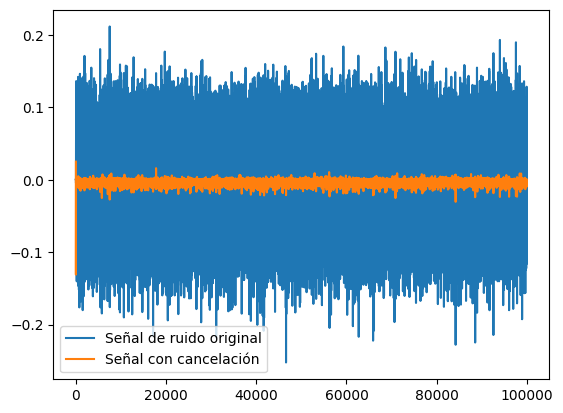

In [ ]:
# Comprobamos prestaciones de atenuación mediante procesado off-line
Ite=100000  # Número de muestras de ruido (iteraciones, en caso de procesado muestra a muestra, a considerar)
x=np.random.randn(Ite)  # Creamos una señal de referencia
d1 = np.array([signal.lfilter(P[:,0],1,x.flatten())])  # Simulamos propagación (obtnemos señal de ruido)

#Añadimos no lienalidad en el primario
d1 = no_linealidad(d1,nl_primario)

#Añadimos no linealidad en referencia
x = no_linealidad(x,nl_referencia)

xr = np.concatenate((np.zeros(L-1),x))
y1 = modelo_nl.predict(xr.reshape(1,len(xr),1),verbose='False')  # Obtenemos la señal que generaría la RN y reproduciría el altavoz
# Añadimos no linealidad en secudario:
y1 = no_linealidad(y1,nl_secundario);

d1_e = signal.lfilter(S[:,0],1,y1.flatten())  # Simulamos la propagación acústica de la señal generada

plt.plot(d1.flatten())
e = d1.flatten() + d1_e.flatten()
plt.plot(e)  # Simulamos la suma acústica
plt.legend(['Señal de ruido original','Señal con cancelación']);
print('Atenuación lograda:', 10*np.log10(np.mean(d1.flatten()[1000:]**2)/np.mean(e[1000:]**2)),'dB')

El modelo no lineal parace que mejora el comportamiento del modelo lienal cuando hay no linealidades en el camino primario y/o secundario.

Se pueden obtener los parámetros entrenables que definen el modelo que, en este caso, se corresponden con los coeficientes de un filtro, las ponderaciones de los diferentes modelos de no linealidad y las constantes del modelo polinómico empleado. De esta manera de puede proponer un sencillo filtrado seguido de unas pocas operaciones que modelan la no linealidad, y ejecutarlo muestra a muestra sin latencia.

Desglosamos el modelo:

In [ ]:
# Obtenemos el nonmbre y dimensiones de cada capa para identificar los bloques
for layer in modelo_nl.layers:
    print(f"{layer.name}: {[w.shape for w in layer.get_weights()]}")

input_layer_6: []
conv1d_6: [(600, 1, 1)]
activation: []
polinomio: [(4,)]
concatenate: []
dense: [(3, 1)]


Peso sistema lineal: [-0.17262158] Peso tangente hiperbólica: [-1.0664792] Peso polinomio: [-0.42995915]
a0: -0.46996558 a1: 0.021743827 a2: 0.0633808 a3: 0.041496012


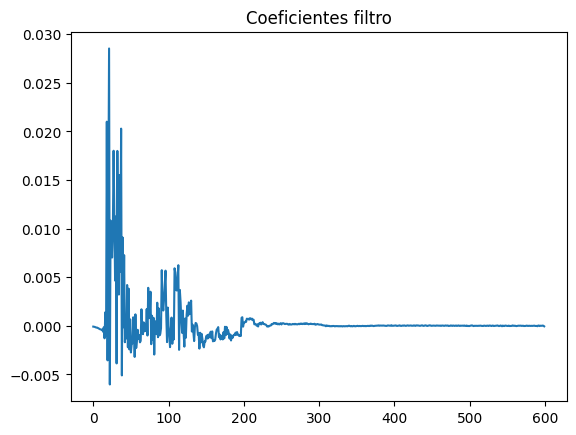

In [ ]:
# Coeficientes del filtro
w = np.array(modelo_nl.layers[1].weights)[0,::-1,0,0]
plt.plot(w)
plt.title('Coeficientes filtro');

# Pesos de las combinaciones no lineales:
capa_comb =  np.array(modelo_nl.layers[5].weights)
print('Peso sistema lineal:',capa_comb[0][0], 'Peso tangente hiperbólica:',capa_comb[0][1], 'Peso polinomio:',capa_comb[0][2]  )

# Coeficientes polinomios
capa_poli =  np.array(modelo_nl.layers[3].weights)
print('a0:',capa_poli[0,0], 'a1:',capa_poli[0,1], 'a2:',capa_poli[0,2], 'a3:',capa_poli[0,3] )



# Cosas que hacer:

* Introducir en la función de coste señales intermedias (señal de salida lineal)
* pensar en un mejor modelo no lineal (quizás añadiendo no linealidades antes del bloque convolucional)
* Volver a los sistemas no lineales con memoria (redefinir Volterra como producto vector-vector)
* Entrenar parte lienal y no lineal por separado?





In [ ]:
def custom_loss(y_true, y_pred):
    final_output = y_pred[:, 0]      # Supongamos que y_pred[:, 0] = salida final
    linear_output = y_pred[:, 1]     # y_pred[:, 1] = salida lineal (extraída en el modelo)

    loss_final = tf.reduce_mean(tf.square(y_true - final_output))
    loss_linear = tf.reduce_mean(tf.square(y_true - linear_output))
    return loss_final + 0.2 * loss_linear  # Peso ajustable

In [ ]:
modelo_lineal = crea_modelo_lineal(Tam_FA=600)
modelo_lineal.compile(optimizer='adam', loss=loss_fn, metrics=[metric_fn])
modelo_lineal.fit(X_train, -y_train[:,L-1:],epochs=Max_epoc, batch_size=batch_size, validation_data=(X_val, -y_val[:,L-1:]),callbacks=[early_stop])

# Construimos modelo no lineal completo
modelo_nolineal = crea_modelo_nolineal(Tam_FA=600, grado=3)

# Copiamos los pesos de la capa Conv1D entrenada
modelo_nolineal.layers[1].set_weights(modelo_lineal.layers[1].get_weights())

# Congelamos la capa Conv1D (la parte lineal del modelo)
modelo_nolineal.layers[1].trainable = False

modelo_nolineal.compile(optimizer='adam', loss=loss_fn, metrics=[metric_fn])
modelo_nolineal.fit(X_train, -y_train[:,L-1:],epochs=Max_epoc, batch_size=batch_size, validation_data=(X_val, -y_val[:,L-1:]),callbacks=[early_stop])

modelo_nolineal.layers[1].trainable = True  # Descongelar Conv1D
modelo_nolineal.compile(optimizer='adam', loss=loss_fn, metrics=[metric_fn])
modelo_nolineal.fit(X_train, -y_train[:,L-1:],epochs=Max_epoc, batch_size=batch_size, validation_data=(X_val, -y_val[:,L-1:]),callbacks=[early_stop])
